In [ ]:
!pip install thop

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from thop import profile
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve, auc, confusion_matrix

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [ ]:
# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        out = nn.functional.softmax(out, dim=1)
        return out


class MultiLayerBiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        # self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size*2, num_classes) # *2 to account for bidirectional LSTM

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(x.device) # *2 to account for bidirectional LSTM
        c0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(x.device) # *2 to account for bidirectional LSTM
        # Forward propagate bidirectional LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        out = nn.functional.softmax(out, dim=1)
        return out

In [ ]:
# Load the features and labels from numpy arrays
train_features = torch.from_numpy(np.load('/content/train_features.npy')).float()
train_labels = torch.from_numpy(np.load('/content/train_labels.npy')).long()
test_features = torch.from_numpy(np.load('/content/test_features.npy')).float()
test_labels = torch.from_numpy(np.load('/content/test_labels.npy')).long()

# Create dataset instances
train_dataset = CustomDataset(train_features, train_labels)
test_dataset = CustomDataset(test_features, test_labels)

# Define DataLoaders with batch size
batch_size = 30  # Define your batch size here
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# set random seeds
seed = 43 # 43
torch.manual_seed(seed)
np.random.seed(seed)

input_size = train_features.shape[-1]
hidden_size = 3
num_layers = 3
num_classes = len(np.unique(train_labels))

# Instantiate the LSTM model
model = LSTMClassifier(input_size, hidden_size, num_classes)

if torch.cuda.is_available():
    model = MultiLayerBiLSTMClassifier(input_size, hidden_size, num_layers, num_classes).cuda()
else:
    model = MultiLayerBiLSTMClassifier(input_size, hidden_size, num_layers, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001)

train_f1_scores = []
test_f1_scores = []

# Train the LSTM model
num_epochs = 60
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

train_preds, train_targets = [], []

train_precision_scores = []
train_recall_scores = []
test_precision_scores = []
test_recall_scores = []

In [ ]:
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    for batch_features, batch_labels in train_loader:
        if torch.cuda.is_available():
            batch_features = batch_features.cuda()
            batch_labels = batch_labels.cuda()

        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += batch_labels.size(0)
        train_correct += (predicted == batch_labels).sum().item()

        train_preds.extend(predicted.cpu().numpy())
        train_targets.extend(batch_labels.cpu().numpy())

    train_loss /= len(train_loader)
    train_accuracy = 100 * train_correct / train_total

    precision, recall, f1_score, _ = precision_recall_fscore_support(
    train_targets, train_preds, average='weighted', zero_division=0)
    train_f1_scores.append(f1_score)

    train_precision, train_recall, _, _ = precision_recall_fscore_support(
        train_targets, train_preds, average='binary', zero_division=0)
    train_precision_scores.append(train_precision)
    train_recall_scores.append(train_recall)

    # Testing loop
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    # f1 score
    test_preds, test_targets = [], []

    print(f'Epoch {epoch+1}/{num_epochs}')

    # AUC
    all_test_labels = []
    all_test_scores = []

    # ROC
    test_probabilities = []
    test_ground_truth = []

    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            if torch.cuda.is_available():
                batch_features = batch_features.cuda()
                batch_labels = batch_labels.cuda()

            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_total += batch_labels.size(0)
            test_correct += (predicted == batch_labels).sum().item()

            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            all_test_scores.extend(probabilities[:, 1].cpu().numpy()) # Assuming binary classification
            all_test_labels.extend(batch_labels.cpu().numpy())

            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            test_probabilities.append(probabilities.cpu())
            test_ground_truth.append(batch_labels.cpu())

        # AUC
        test_preds.extend(predicted.cpu().numpy())
        test_targets.extend(batch_labels.cpu().numpy())

    # ROC
    test_probabilities = torch.cat(test_probabilities, dim=0)
    test_ground_truth = torch.cat(test_ground_truth, dim=0)

    test_loss /= len(test_loader)
    test_accuracy = 100 * test_correct / test_total

    test_precision, test_recall, _, _ = precision_recall_fscore_support(
        test_targets, test_preds, average='binary', zero_division=0)
    test_precision_scores.append(test_precision)
    test_recall_scores.append(test_recall)

    # Calculate ROC and AUC
    fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_scores)
    auc_score = roc_auc_score(all_test_labels, all_test_scores)

    print(f'Epoch {epoch+1}/{num_epochs}, AUC: {auc_score:.4f}')

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    precision, recall, f1_score, _ = precision_recall_fscore_support(
    test_targets, test_preds, average='weighted', zero_division=0)
    test_f1_scores.append(f1_score)

    # Print testing loss and accuracy
    print(f'Epoch {epoch+1}/{num_epochs} - '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Train F1 Score: {train_f1_scores[-1]:.4f}, '
          f'Train Precision: {train_precision_scores[-1]:.4f}, '
          f'Train Recall: {train_recall_scores[-1]:.4f}, '
          f'Test Loss: {test_loss:.4f}, '
          f'Test Accuracy: {test_accuracy:.2f}%, '
          f'Test F1 Score: {test_f1_scores[-1]:.4f}, '
          f'Test Precision: {test_precision_scores[-1]:.4f}, '
          f'Test Recall: {test_recall_scores[-1]:.4f}')

Epoch 1/60
Epoch 1/60, AUC: 0.9400
Epoch 1/60 - Train Loss: 0.7338, Train Accuracy: 38.30%, Train F1 Score: 0.2122, Train Precision: 0.0000, Train Recall: 0.0000, Test Loss: 0.7989, Test Accuracy: 8.26%, Test F1 Score: 0.0053, Test Precision: 0.0000, Test Recall: 0.0000
Epoch 2/60
Epoch 2/60, AUC: 0.9856
Epoch 2/60 - Train Loss: 0.7158, Train Accuracy: 38.30%, Train F1 Score: 0.2122, Train Precision: 0.0000, Train Recall: 0.0000, Test Loss: 0.7613, Test Accuracy: 8.26%, Test F1 Score: 0.0431, Test Precision: 0.0000, Test Recall: 0.0000
Epoch 3/60
Epoch 3/60, AUC: 0.9800
Epoch 3/60 - Train Loss: 0.6920, Train Accuracy: 38.30%, Train F1 Score: 0.2122, Train Precision: 0.0000, Train Recall: 0.0000, Test Loss: 0.7233, Test Accuracy: 8.26%, Test F1 Score: 0.0053, Test Precision: 0.0000, Test Recall: 0.0000
Epoch 4/60
Epoch 4/60, AUC: 0.9822
Epoch 4/60 - Train Loss: 0.6585, Train Accuracy: 47.94%, Train F1 Score: 0.2623, Train Precision: 1.0000, Train Recall: 0.0390, Test Loss: 0.6755, Test 

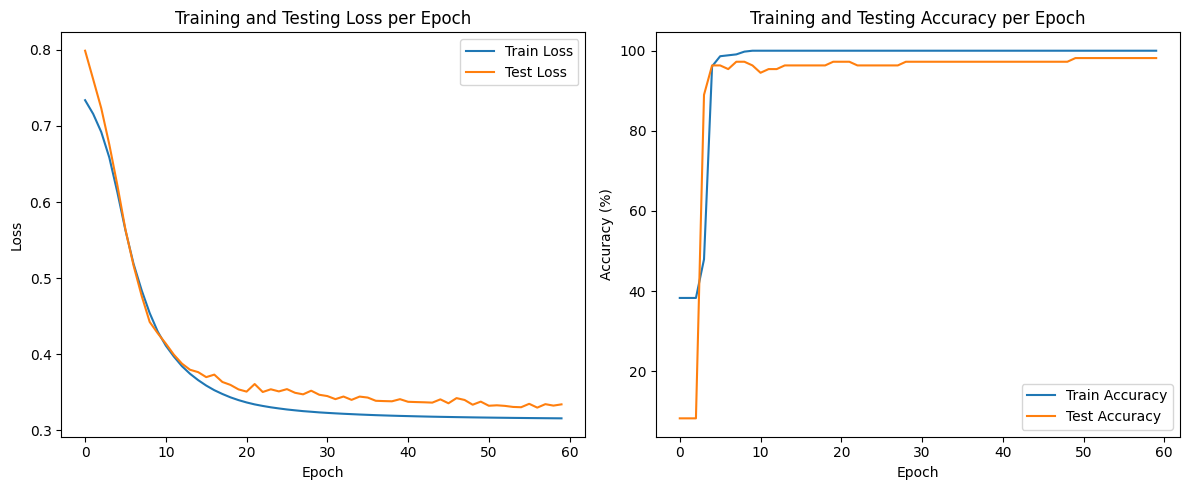

In [ ]:
plt.figure(figsize=(12, 5))

# Plot training and testing losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and testing accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Testing Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

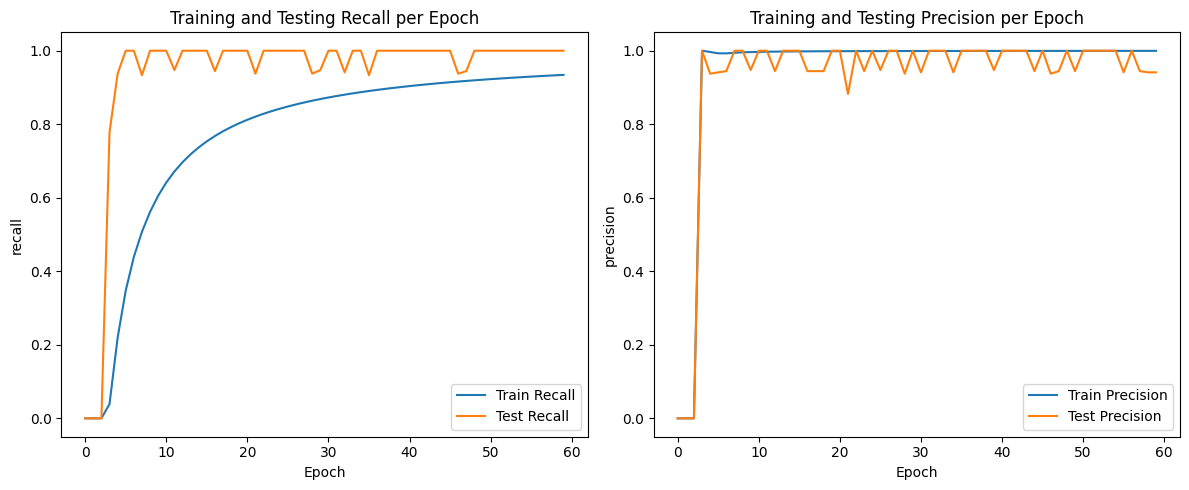

In [ ]:
plt.figure(figsize=(12, 5))

# Plot training and testing losses
plt.subplot(1, 2, 1)
plt.plot(train_recall_scores, label='Train Recall')
plt.plot(test_recall_scores, label='Test Recall')
plt.title('Training and Testing Recall per Epoch')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.legend()

# Plot training and testing accuracies
plt.subplot(1, 2, 2)
plt.plot(train_precision_scores, label='Train Precision')
plt.plot(test_precision_scores, label='Test Precision')
plt.title('Training and Testing Precision per Epoch')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend()

plt.tight_layout()
plt.show()

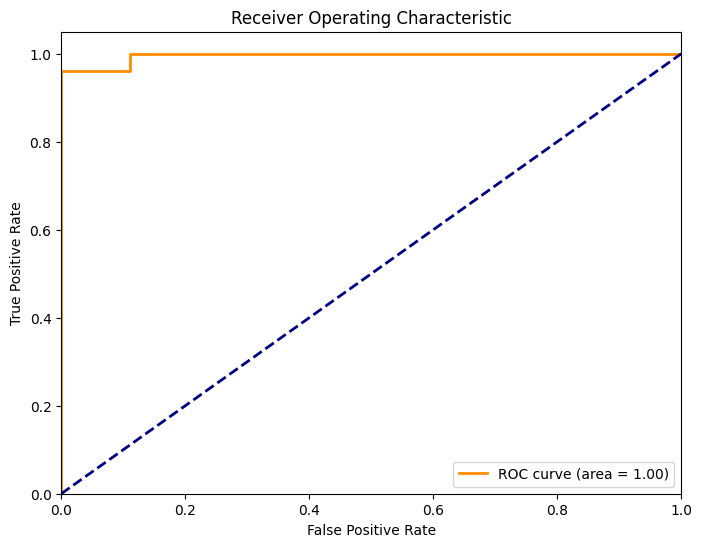

In [ ]:
fpr, tpr, thresholds = roc_curve(test_ground_truth, test_probabilities[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
# ROC
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# show graph
plt.show()

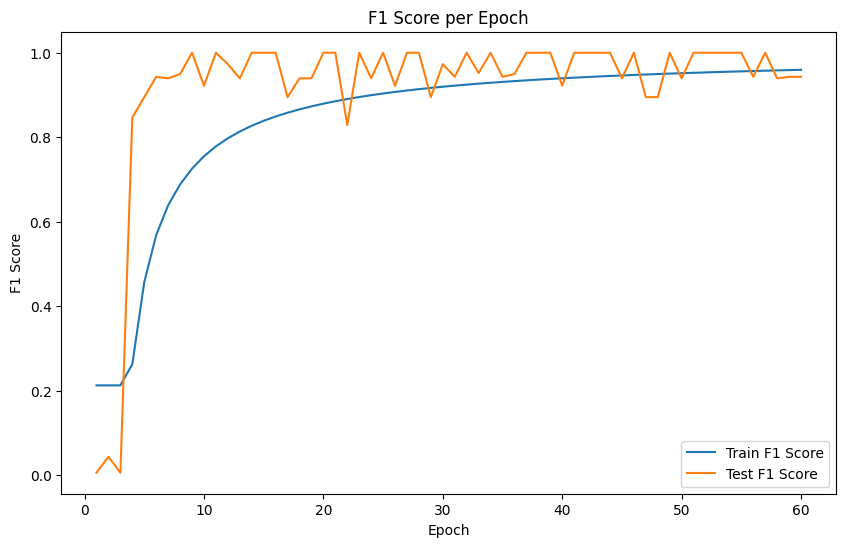

In [ ]:
# F1 score
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs+1), test_f1_scores, label='Test F1 Score')
plt.title('F1 Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

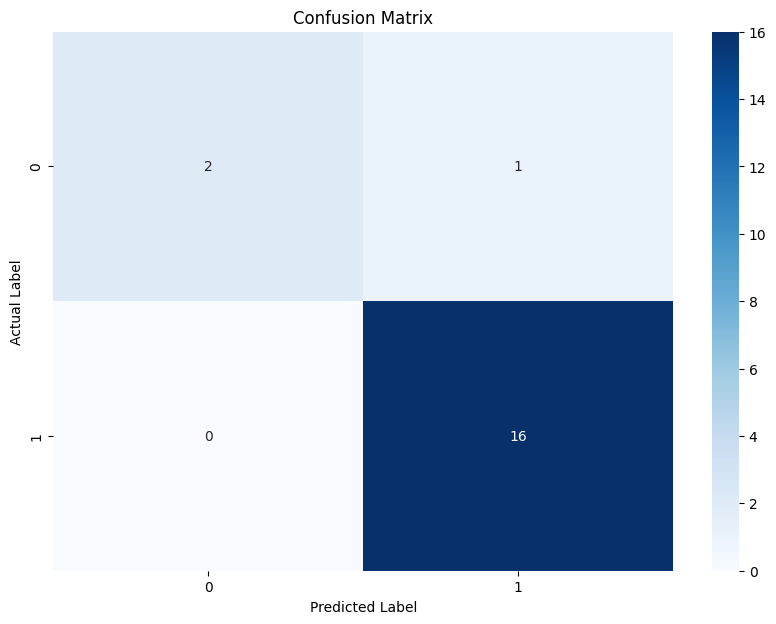

In [ ]:
cm = confusion_matrix(test_targets, test_preds)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()